# Lab 08 - Evaluation

In this lab we are going through a simple evaluation process involving 2 machine learning models.

First, let's import the necessary libraries we need.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets

Now we need a dataset. This week we will use the breast cancer dataset from sci-kit learn.

In [2]:
data = datasets.load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=['cancer_type'])

y.value_counts()

cancer_type
1              357
0              212
dtype: int64

We can see that our data set is not well-balanced.

Unbalanced dataset is a dataset which the target variable has one class that has a lot more observations compared to
 the other classes. Because of that machine learning algorithms tends to categorise more new instances into the
 majority class than to others. In testing also, this will give a false sense of high accuracy.

If a dataset is approximately balanced, for example 55%-45%, the effects of this phenomena is
relatively low. But when the disparity get higher, the effects increase. However, deciding where the boundary between
balanced and unbalanced dataset is a judgement call that gets better with experience.

### Dividing the data
First part of evaluation is to divide data into train, validation and test sets.

In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val)

#### Model selection
Then we need two models to evaluate. Let's take a K-Nearest Neighbours (KNN) model and a Logistic regression model as examples.

In [4]:
log_reg = LogisticRegression(max_iter=5000)

In [5]:
knn = KNeighborsClassifier(n_neighbors=5)

### Timing performance

One of the performance metrics we overlooked until now is computing performance. In production environments that are
time critical like self-driving vehicles, drones, biomedical equipments, etc. we need our results withing the time
constraints each system has. So when creating a machine learning solution for such problem, computing performance of
the model plays a huge role on overall model performance.

We can use built in magic commands in Ipython environment to measure the computing performance. First let's measure
the training time for both models.

In [6]:
%%time
log_reg.fit(X_train, y_train.values.ravel())

Wall time: 489 ms


LogisticRegression(max_iter=5000)

In [7]:
%%time
knn.fit(X_train, y_train.values.ravel())

Wall time: 2.99 ms


KNeighborsClassifier()

Now let's measure the prediction time for each model.

In [8]:
%%time
pred_log_reg = log_reg.predict(X_val)

Wall time: 999 µs


In [9]:
%%time
pred_knn = knn.predict(X_val)

Wall time: 7.98 ms


From above analysis we can see that, the KNN model is faster to train, but slow when predicting. Logistic regression
model on other hand is slower in the training phase, but manage to predict quicker than KNN.

### Predicting performance
Let's evaluate the models using their predicting performance. First let's generate confusion matrices and classification
reports for all the models.

In [10]:
confusion_matrix(y_true=y_val, y_pred=pred_log_reg)

array([[38,  1],
       [ 1, 67]], dtype=int64)

In [11]:
print(classification_report(y_true=y_val, y_pred=pred_log_reg))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        39
           1       0.99      0.99      0.99        68

    accuracy                           0.98       107
   macro avg       0.98      0.98      0.98       107
weighted avg       0.98      0.98      0.98       107



In [12]:
confusion_matrix(y_true=y_val, y_pred=pred_knn)

array([[35,  4],
       [ 3, 65]], dtype=int64)

In [13]:
print(classification_report(y_true=y_val, y_pred=pred_knn))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        39
           1       0.94      0.96      0.95        68

    accuracy                           0.93       107
   macro avg       0.93      0.93      0.93       107
weighted avg       0.93      0.93      0.93       107



Upto now we can see that the logistic regression model performs better than the K-Nearest Neighbours model.

### ROC curve

As we discussed earlier, when the dataset is not balanced, like our breast cancer dataset, measures like accuracy does
not give you the full picture of the performance correctly. So we need to have more sophisticated performance measures.

One of the most popular methods is the ROC curve. Let's plot both of our models' ROC curves. Sci-kit learn provides the method called *plot_roc_curve*. You can find more details on this method
[here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html). We can give our model,
 test datasets, and a name for the plot, and it will return a Display object that holds the plot data. You can use this
 object in future plots as well.

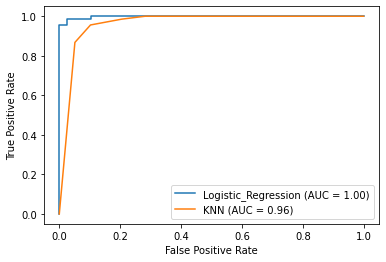

In [14]:
ax = plt.gca()
plot_log_reg = plot_roc_curve(estimator=log_reg, X=X_val, y=y_val, ax=ax, name='Logistic_Regression')
plot_knn = plot_roc_curve(estimator=knn, X=X_val, y=y_val, ax=ax, name='KNN')

According to these ROC curves you can see that the logistic regression model performs better. To get a more precise
Area under the ROC curve value, we can use *roc_auc_score* method. But we have to input the probability values of our
prediction. In a standard implementation of ML algorithm in Sci-kit learn you can find *predict_proba()* function
call which will gives us the probabilities of the predictions.

In [15]:
pred_scores = log_reg.predict_proba(X_val)
print('Area under the curve for logistic regression model: {}'.format(roc_auc_score(y_true=y_val,
                                                                                    y_score=pred_scores[:, 1])))

Area under the curve for logistic regression model: 0.997737556561086


In [16]:
pred_scores = knn.predict_proba(X_val)
print('Area under the curve for KNearestNeighbours model: {}'.format(roc_auc_score(y_true=y_val,
                                                                                   y_score=pred_scores[:, 1])))

Area under the curve for KNearestNeighbours model: 0.9628582202111614


### Cross-Validation

At this point we know that our Logistic regression model works better for our current train and validation datasets.
 But this does not mean it will be same if we train the same model with different sample of instances. So to get an idea
  about how our models work with different training samples, we can use cross-validation.

Although we use cross-validation here for the purpose stated above, in Machine learning we use cross validation for
one other major reason. That is to get the maximum use out of the data. Using cross-validation we can use all the data in
both training and validation phases. So if your dataset is very small, cross validation is the best way you overcome
that issue.

we are using *cross_val_score()* method in sklearn to get performance scores from the fold runs. Let's do a
10 fold cross-validation using all the train and validation data on logistic regression model. Here we are using macro
average f1 score as the scoring method.

In [17]:
scores = cross_val_score(estimator=log_reg, X=X_train_val, y=y_train_val.values.ravel(), cv=10, scoring='f1_macro')

In [18]:
print('F1_score: %0.2f std: %0.2f'%(scores.mean(), scores.std()))

F1_score: 0.94 std: 0.02


Let's do the same for KNN model.

In [19]:
scores = cross_val_score(estimator=knn, X=X_train_val, y=y_train_val.values.ravel(), cv=10, scoring='f1_macro')

In [20]:
print('F1_score: %0.2f std: %0.2f'%(scores.mean(), scores.std()))

F1_score: 0.93 std: 0.03


From these results also, we can conclude that our logistic regression model performs better than the KNN one. So
overall we can choose that model as our solution.

Final step is to test our model against the test dataset.

In [21]:
pred = log_reg.predict(X_test)
print(classification_report(y_true=y_test, y_pred=pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        49
           1       0.96      0.98      0.97        94

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



## Task
Use the dataset you cleaned in lab02 and lab03.

* Develop 3 different models using different machine learning algorithms.
* Identify which performance measures you use by analyzing the problem.
* Do hyperparameter tuning using *cross_val_score()* for every model and find the best parameters for each.
* Do a complete performance analysis using the techniques you learned in the class and the lab and find the best model
 out of 3.
* Run the model on test dataset and get the performance numbers.